<a href="https://colab.research.google.com/github/modichirag/sbi_tutorial/blob/main/SBI_tutorial_mexico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch


In [4]:
!pip install --quiet emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 657.2 kB/s eta 0:00:00


In [5]:
!pip install  --quiet  sbi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 1-D Toy problem

Let's set up a simple 1-dimensional toy problem to get started with SBI.  

Say we are interested in the estimating the age of a person ($\theta: age$) given their height $(x: height)$.

To keep things simple, we will assume that the height of the person is distributed as a Gaussian distribution where the mean and the variance of the distribution depend on the age of the person depend as follows:

$height \sim \mathcal{N}(\mu, \sigma^2)$ \\
where \\
$\mu = - 0.04 *(age - 60)^2 + 170$ \\
$\sigma^2 = - 0.04 *(age - 60)^2 + 170$ \\

Though not relevant for the turorial, this ad-hoc relation captures some of the intuition we might have about height-age relationship, for e.g., \\
- it gets the average height of a baby and a 60 year old reasonably correct
- the height of the person increases faster when young and asymptotes as they mature followed by a slight decrease as they stoop in the old age (say after age 60)
- the variance in the height is larger when the mean height is larger  

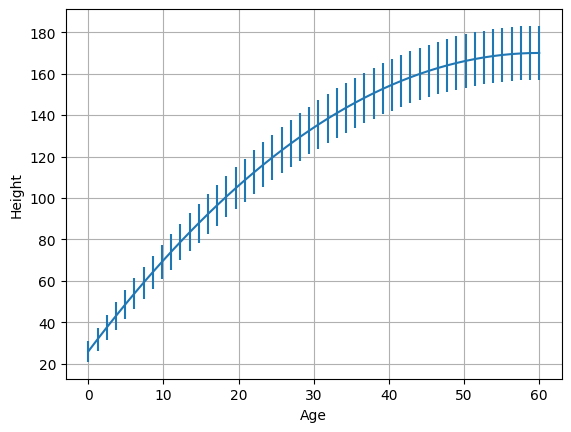

In [6]:
def mean_height(age):
    h = -0.04*(age - 60)**2 + 170
    return h

def var_height(age):
    h = -0.04*(age - 60)**2 + 170
    return h

#Let us visualize what this distribution looks like
ages = np.linspace(0, 60)
h_mean = mean_height(ages)
h_var = var_height(ages)
plt.errorbar(ages, h_mean, h_var**0.5)
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid()

This defines a data-generating process, or a simulator which takes in the age and outputs a height of the person.

In [65]:
def simulator(age):
    # Generate samples from N(mu, sigma) where mu and sigma depend on age

    mu = mean_height(age)
    var = var_height(age)

    # Just some book-keeping to handle both scalar and vector inputs.
    if type(age) == float:
        h = mu + var**0.5 * np.random.normal()
    elif type(age) == np.ndarray :
        h = mu + var**0.5 * np.random.normal(size=mu.shape[0])
    return h



## Explicit inference with MCMC

Given an observation of height (data), we wish to infer the age of the person i.e. we are interested in estimating the posterior distribution $p(\theta | x)$

According to Baye's theorem:
$p(\theta | x) \propto p(x | \theta) \times p(\theta) $

The likelihood distribution of the observed data (height) is described above:  p(x | \theta). \\
We also need a prior distribution on $\theta$, the parameters of interest i.e. age.
Let us assume this to be a uniform distribution
$\theta \sim \mathcal{U}(0, 65)$

In [8]:
def log_likelihood(theta, x):
    mu = mean_height(theta)
    var = var_height(theta)
    lk =   -0.5* ((mu-x)**2)/var
    return lk

def log_prior(theta):
    lp = 0
    if (theta < 0) or (theta > 65): lp = -np.inf
    else: lp = 0.
    return lp

def log_prob(theta, x):
    lk = log_likelihood(theta, x)
    lp = log_prior(theta)
    log_prob = lk + lp
    return log_prob


Let us construct a mock data for say a person of age 20.

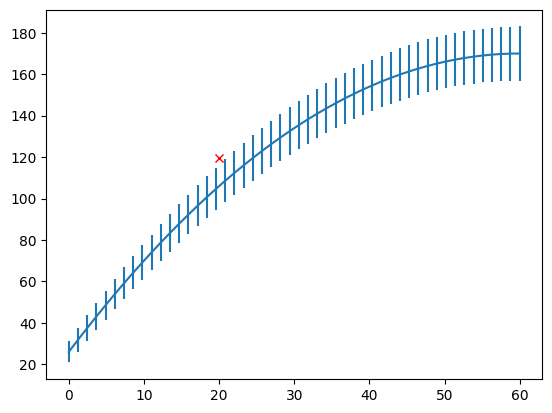

In [66]:
np.random.seed(10)
#np.random.seed(2)
age = 20.
height = simulator(age)

# Visualize the data
plt.errorbar(ages, h_mean, h_var**0.5)
plt.plot(age, height, 'x', color='red')

### Sampling

Now that we have defined the posterior distribution and generated a mock data sample, we can use MCMC to generate samples from the posterior i.e. the possible ages consistent with the observed height.

We will use emcee package for this which is a great package of small (< 10) dimensional problems.

https://emcee.readthedocs.io/en/stable/

In [67]:
import emcee

In [83]:
# the dimensionality of the problem, and the number of walkers we want to use
ndim, nwalkers = 1, 10

# Initialize the emcee sampler for our problem
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[height])

# generate an initial guess from the prior
p0 = np.random.uniform(0, 60, nwalkers).reshape(-1, 1)

# do a warm-up/burn-in to allow the generated points to come into the posterior
# we do this for 200 steps since it is a simple 1-D problem
state = sampler.run_mcmc(p0, 500)

# reset to clear the previous samples except the last one
# then do the acutual sampling for 1000 steps
sampler.reset()
state = sampler.run_mcmc(state, 1000)
samples = sampler.get_chain() # the output shape will be (samples, chain, dim)

Lets visualize these chains to make sure they have mixed well

(1000, 10, 1)


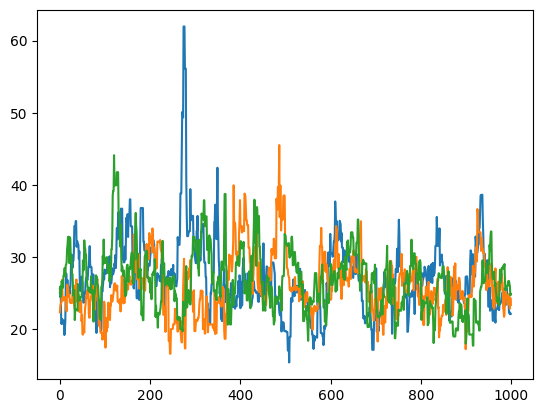

In [84]:
print(samples.shape)
plt.plot(samples[:, :3, 0]);

Finally, lets plot the final posterior distrbution

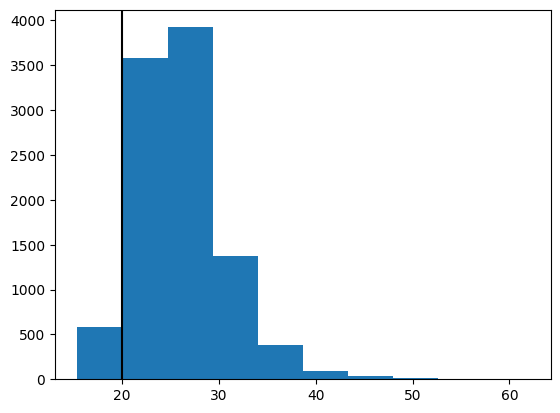

In [85]:
plt.hist(samples.flatten())
plt.axvline(age, color='k')

## Implicit inference with SBI

To do the explicit inference as we discussed above, we needed to know the likelihood distribution of the data (heights) conditioned on the parameters (age). Often we do not have access to it.

However many times we do have access to the samples from this likelihood distribution. This is precisely what a physical simulator gives you.

In this example, we will assume that we have this data from the simulator described above (or alternatively that you got these samples from surveying the population).
SBI allows us to do the inference in this setting.

Fundamentally, what you do is to use these samples to learn the amortized likelihood, or the posterior distribution using flexible models capable of learning density distributions. Generally, these models are _normalizing flows_ (but they do not necessarily have to be).

Here, we will conduct SBI using normalizing flows using `sbi`, an excellent python package. See
[Tejero-Cantero+(2020)](https://doi.org/10.21105/joss.02505) for details.



In [71]:
# Lets begin with some imports
import sbi.utils as utils
from sbi.inference.base import infer
from sbi import analysis
from sbi.inference import SNPE, SNLE_A #prepare_for_sbi, simulate_for_sbi

In [72]:
# We again need to set the priors, in this case using torch tensors.
# We simply use `sbi' package funcionality for this

prior = utils.BoxUniform(
    low=torch.tensor([0]),
    high=torch.tensor([65])
)


Lets define a normalizing flow model. This is the model that estimates the conditional probability distribution --- i.e. posterior. We will use masked autoregressive flows (MAF; [Papamakarios+(2017)](https://ui.adsabs.harvard.edu/abs/2017arXiv170507057P/abstract)).

Since we're estimating a relatively simple example, we'll go with some random architecture


In [73]:
nhidden = 128
nblocks = 5

maf_model = utils.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

Now we can set up the SBI. Note that we use the SNPE module, which stands for Sequential Neural Posterior Estimation. We will *not* be using the sequential
feature, which allows us to sequentially generate more samples using our forward model. However, if you're interested the `sbi` package is fairly well documented with examples: https://www.mackelab.org/sbi/tutorial/16_implemented_methods/


Instead here we will generate the samples from the simulator beforehand and then use these to train SBI. In this way, the SBI pricedure is amortized i.e. once trained, it can be used with many new data points for inference.

Sequential approaches depend on data and in any round, they generate simulations for training more effectively in a region from the approximate posterior distribution of the previous round.

In [74]:
# generate simulations from the simulator

num_sims = 1000
theta = prior.sample((num_sims,))

x = simulator(theta[:, 0].numpy())
# some bookkeeping to change data into right shape and data-type
x = torch.from_numpy(x.reshape(-1, 1).astype(np.float32))


In [87]:
# Let us set-up the inference object now

method = 'SNLE' #SNPE or SNLE or SNRE
inference = SNPE(prior=prior)

# append the simulations to the inference object
_ = inference.append_simulations(theta, x).train()

# Finally, train the normalizing flow to approximate the posterior
posterior = inference.build_posterior()


/usr/local/lib/python3.10/dist-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 66 epochs.

In [88]:
samples2 = posterior.sample((1000,), x=torch.from_numpy(np.array([height]).astype(np.float32).reshape(-1, 1))).numpy().flatten()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

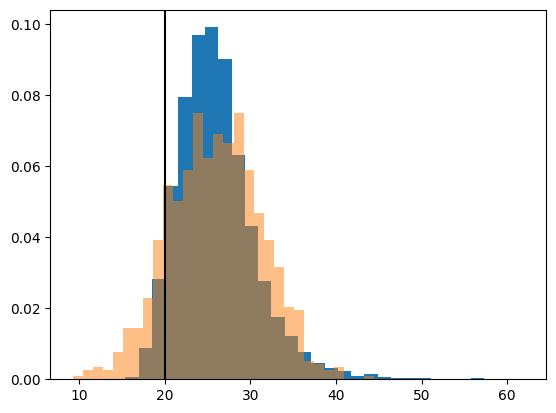

In [89]:
plt.hist(samples.flatten(), density=True, bins=30)
plt.hist(samples2, alpha=0.5, density=True, bins=30)
plt.axvline(age, color='k')

# Power spectrum

In [ ]:
!pip install classylss

  Using cached classylss-0.2.9.tar.gz (244 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!conda version

/bin/bash: line 1: conda: command not found
